In [1]:
from fastai.vision.all import *

In [2]:
from pathlib import Path
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Preprocess data and create csv

In [3]:
NB_DIR = Path.cwd()
DATA_DIR = NB_DIR/'..'/'data' 

In [4]:
df = pd.read_csv(DATA_DIR/'csv'/'train_data.csv')

In [5]:
mask = Image.open(df.mask_path[20])
mask.shape, np.unique(mask)

((256, 256), array([  0, 255], dtype=uint8))

In [6]:
df.is_valid.value_counts()

False    40
True      6
Name: is_valid, dtype: int64

In [7]:
#Followed the steps from: https://walkwithfastai.com/Binary_Segmentation

In [8]:
def n_codes(fnames, is_partial=True): 
    "Gather the codes from a list of `fnames`"

    vals = set()
    for fname in fnames:
        msk = np.array(PILMask.create(fname))
        for val in np.unique(msk):
            if val not in vals: vals.add(val)
    vals = list(vals)
    p2c = dict()
    for i,val in enumerate(vals): p2c[i] = vals[i]
    return p2c

In [9]:
p2c = n_codes(df.mask_path.to_list())
p2c

{0: 0, 1: 255}

In [10]:
def get_msk(fn, pix2class):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = fn.mask_path
    msk = np.array(PILMask.create(fn))
    mx = np.max(msk)
    for i, val in enumerate(p2c): msk[msk==p2c[i]] = val
    return PILMask.create(msk)

In [11]:
codes = [0, 1]

In [12]:
get_y = lambda o: get_msk(o, p2c)

In [13]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_x=ColReader('img_path'),
                   splitter=ColSplitter('is_valid'),
                   get_y=get_y,
                   item_tfms=CropPad(224), #TODO: Resize(128) for progressize resizing
                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

### Looking at the data

In [14]:
bs = 8

In [15]:
dls = binary.dataloaders(df, bs=bs)

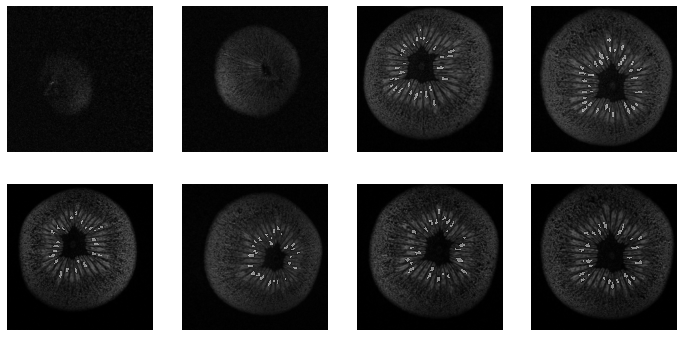

In [16]:
dls.show_batch(cmap='gray', vmin=0, vmax=1)

### Training

In [17]:
learn = unet_learner(dls, resnet18, metrics=[Dice])

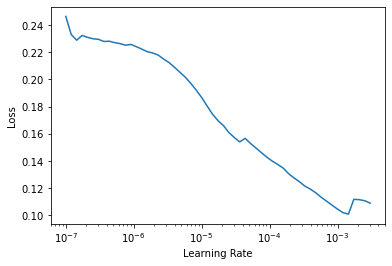

In [18]:
lr_min, lr_steep = learn.lr_find()

In [19]:
lr = lr_min/10
lr

1.4454397605732084e-05

In [20]:
lr = 0.005

In [21]:
learn.fit_one_cycle(30, lr)

epoch,train_loss,valid_loss,dice,time
0,0.153648,0.081694,0.000000,00:05
1,0.097268,0.063694,0.000000,00:04
2,0.076001,0.044746,0.000000,00:04
3,0.059950,0.033457,0.000000,00:04
4,0.049250,0.027332,0.000000,00:04
5,0.041314,0.021440,0.203466,00:04
6,0.035451,0.018564,0.712919,00:04
7,0.032537,0.022055,0.197491,00:05
8,0.029667,0.018316,0.419573,00:05
9,0.026565,0.012640,0.750715,00:05


In [22]:
learn.unfreeze()

In [23]:
lr /= 2

In [24]:
learn.fit_one_cycle(30, slice(lr/10, lr))

epoch,train_loss,valid_loss,dice,time
0,0.004721,0.007435,0.844361,00:05
1,0.004802,0.007498,0.843155,00:05
2,0.004671,0.007357,0.848673,00:05
3,0.004688,0.007358,0.847242,00:05
4,0.004651,0.007573,0.838759,00:05
5,0.004933,0.007287,0.851415,00:04
6,0.005178,0.008297,0.832659,00:05
7,0.005222,0.008505,0.815354,00:04
8,0.005145,0.007973,0.834427,00:05
9,0.005062,0.007356,0.846656,00:04


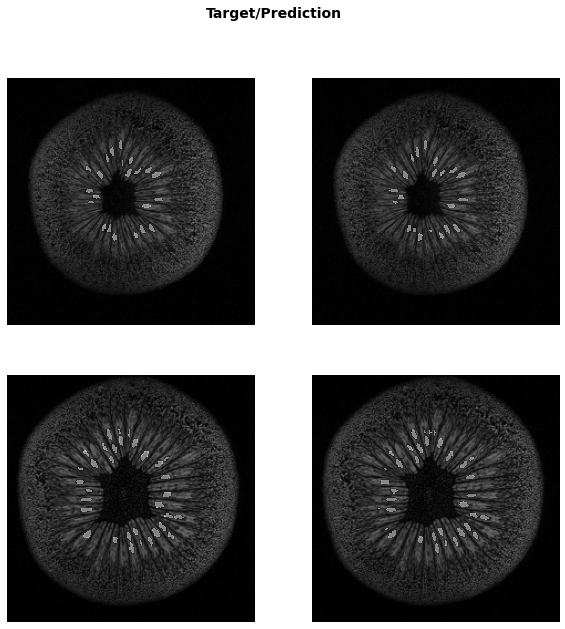

In [25]:
learn.show_results(cmap='gray', vmin=0, vmax=1, max_n=16, figsize=(10,10))

In [26]:
learn.save('stage-1');

### Train on the entire training set

In [27]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_x=ColReader('img_path'),
                   splitter=RandomSplitter(valid_pct=0),
                   get_y=get_y,
                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]) #size=(128)

In [28]:
dls = binary.dataloaders(df, bs=bs)

In [29]:
learn = unet_learner(dls, resnet18, metrics=[Dice])
learn.load('stage-1');

In [30]:
learn.unfreeze()

/home/sathiesh/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


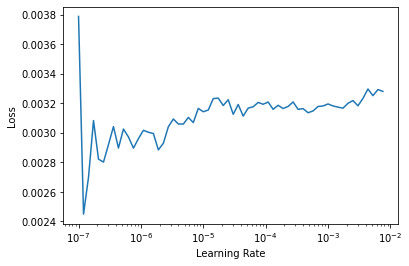

In [31]:
lr_min, lr_steep = learn.lr_find()

In [32]:
lr = lr_min/10
lr 

1.905460749185295e-08

In [33]:
learn.fit_one_cycle(3, slice(lr/10, lr))

epoch,train_loss,valid_loss,dice,time
0,0.003739,None,None,00:05
1,0.003603,None,None,00:05
2,0.003339,None,None,00:05


In [34]:
learn.save('final');

### Intepretation

In [35]:
learn.load('final');

In [36]:
df_test = pd.read_csv(DATA_DIR/'csv'/'test_data.csv')

In [37]:
df_test.head()

,img_path
0,/home/sathiesh/machine_learning/BMED360/nbs/../data/kiwi/2d_imgs/slice_100.png
1,/home/sathiesh/machine_learning/BMED360/nbs/../data/kiwi/2d_imgs/slice_101.png
2,/home/sathiesh/machine_learning/BMED360/nbs/../data/kiwi/2d_imgs/slice_102.png
3,/home/sathiesh/machine_learning/BMED360/nbs/../data/kiwi/2d_imgs/slice_103.png
4,/home/sathiesh/machine_learning/BMED360/nbs/../data/kiwi/2d_imgs/slice_104.png


In [38]:
idx = 62
test_slice_fn = df_test.img_path.to_list()[idx]

In [39]:
pred,*_ = learn.predict(test_slice_fn)

In [40]:
img = Image.open(test_slice_fn)

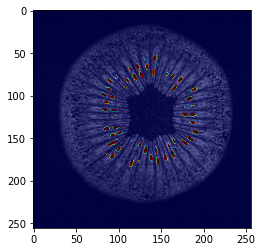

In [41]:
plt.imshow(img, cmap='gray')
plt.imshow(pred, cmap='jet', alpha=0.5)
plt.show()

### Predict on training and test images and stack them to 3D mask

In [42]:
img_list = sorted(glob(str(DATA_DIR/'2d_imgs'/'*')),key=os.path.getmtime)

In [43]:
pred_list = []
for fn in img_list: 
    pred,*_ = learn.predict(fn);
    pred_list.append(np.array(pred));

In [44]:
pred_mask = np.dstack(pred_list).astype(dtype=np.int16)
pred_mask.shape

(256, 256, 128)

In [45]:
import nibabel as nib

In [46]:
img_data = nib.load(DATA_DIR/'kiwi_20050217191129_131073_RARE_high_res_axial.nii.gz')#.get_fdata()

In [47]:
img_data.get_fdata().shape

(256, 256, 128)

In [48]:
pred_nii_mask = nib.Nifti1Image(pred_mask, affine=img_data.affine)

In [49]:
pred_nii_mask

In [50]:
nib.save(pred_nii_mask, str(DATA_DIR/'pred_mask.nii.gz'))

In [51]:
from scipy.ndimage.measurements import label

In [52]:
labeled_array, nseeds = label(pred_mask)

In [53]:
str(nseeds -1)

'1057'